In [1]:
%matplotlib notebook
%matplotlib inline

In [2]:
# importing necessary libraries for the current preliminary phase of the 'Water Allocation Price Prediction'
# model development project

import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from keras.models import load_model

In [3]:
# reading the water market transactions data for Goulburn
data_Murray_Goulburn_Murray = pd.read_csv('data_Murray_Goulburn_Murray.csv')

In [4]:
# displaying the data
data_Murray_Goulburn_Murray 

,Total Traded Volume (ML),Volume Weighted Average Price ($),Date
0,120.0,2610.816667,2009-05-01
1,2806.6,672.739543,2009-06-01
2,18812.9,2227.445579,2009-07-01
3,1290.2,2265.075947,2009-08-01
4,240.3,2318.435289,2009-09-01
...,...,...,...
175,595.0,4699.613445,2023-12-01
176,577.5,5918.474405,2024-01-01
177,1080.6,1951.919304,2024-02-01
178,714.4,4044.883819,2024-03-01


In [5]:
# converting the setting the 'Data' column to the 'datetime' format 
data_Murray_Goulburn_Murray["Date"] = pd.to_datetime(data_Murray_Goulburn_Murray["Date"], format = '%Y/%m/%d')

# modifying the current datetime format of the 'Date' and formatting it separately as years and months
data_Murray_Goulburn_Murray["Year"] = data_Murray_Goulburn_Murray["Date"].dt.year
data_Murray_Goulburn_Murray["Month"] = data_Murray_Goulburn_Murray["Date"].dt.month

# extracting processed transaction data only for months of June (6), July (7), and August (8)
data_Murray_Goulburn_Murray_season_3 = data_Murray_Goulburn_Murray[data_Murray_Goulburn_Murray["Month"].between(6, 8)]

# removing the previous date information from the new dataset after creating a new date feature
data_Murray_Goulburn_Murray_season_3 = data_Murray_Goulburn_Murray_season_3.drop(['Year'], axis = 1)
data_Murray_Goulburn_Murray_season_3 = data_Murray_Goulburn_Murray_season_3.drop(['Month'], axis = 1)

# setting the date feature of the dataset as an index
data_Murray_Goulburn_Murray_season_3.set_index('Date', inplace = True)

In [6]:
# displaying the modified data to clearly see the changes made
data_Murray_Goulburn_Murray_season_3.head()

,Total Traded Volume (ML),Volume Weighted Average Price ($)
Date,,
2009-06-01,2806.6,672.739543
2009-07-01,18812.9,2227.445579
2009-08-01,1290.2,2265.075947
2010-06-01,5793.9,2201.404923
2010-07-01,6024.5,2072.838543


In [7]:
# extracting the column of 'Volume Weighted Average Price ($)' from the data
seasonal_price_data = data_Murray_Goulburn_Murray_season_3['Volume Weighted Average Price ($)']

In [8]:
# this function reforms the data as relevant for time series estimation

def data_to_X_y(data, window_size):
    
    data = data.to_numpy()
    X = []
    y = []
    
    for i in range(len(data) - window_size):
        
        row = [[a] for a in data[i:i + window_size]]
        X.append(row)
        
        actual_value = data[i + window_size]
        y.append(actual_value)
    
    return np.array(X), np.array(y)

# choosing a window size and creating appropriate datasets for time series estimation

window_size = 3

X, y = data_to_X_y(seasonal_price_data, window_size)

# displaying shapes of reformed datasets
X.shape, y.shape

((42, 3, 1), (42,))

In [9]:
# generating training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)

# displaying shapes of training and test datasets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((29, 3, 1), (29,), (13, 3, 1), (13,))

In [10]:
# creating an input layer for a deep neural network in an attempt to capture non-linear relationship between the variables of interest
input_layer = Input(shape = (X_train.shape[1], ))

# creating two Dense layers to capture non-linear relationship between the varibales of interest for effective prediction
hidden_1 = Dense(64, activation = 'relu')(input_layer)
hidden_2 = Dense(64, activation = 'relu')(hidden_1)

# creating an output layer with a single unit and the 'linear' activation function since a regression problem is under consideration
output_layer = Dense(1, activation = 'linear')(hidden_2)

# creating a model of the above structure for a deep neural network 
model = tf.keras.Model(inputs = input_layer, outputs = output_layer)

In [11]:
# displaying the model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [12]:
# choosing an optimizer, loss function and a performance metric to comppile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = tf.keras.metrics.MeanSquaredError())

In [13]:
# an initial selection of epochs and batch size
epochs = 300
batch_size = 1

start_time = time.time()

# training the model and recording its training history for further performance analysis
model_training = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 0)

print("The time for training a deep neural network is %s seconds." % (time.time() - start_time))

model.save('model_unpruned.h5')

The time for training a deep neural network is 6.154606580734253 seconds.


In [14]:
# obtaining the model weights
weights = model.get_weights()

In [15]:
# making predictions using the training dataset to evaluate the training performance of the model
train_predictions = model.predict(X_train)

# making predictions using the training dataset to evaluate the training performance of the model
test_new_predictions = model.predict(X_test)

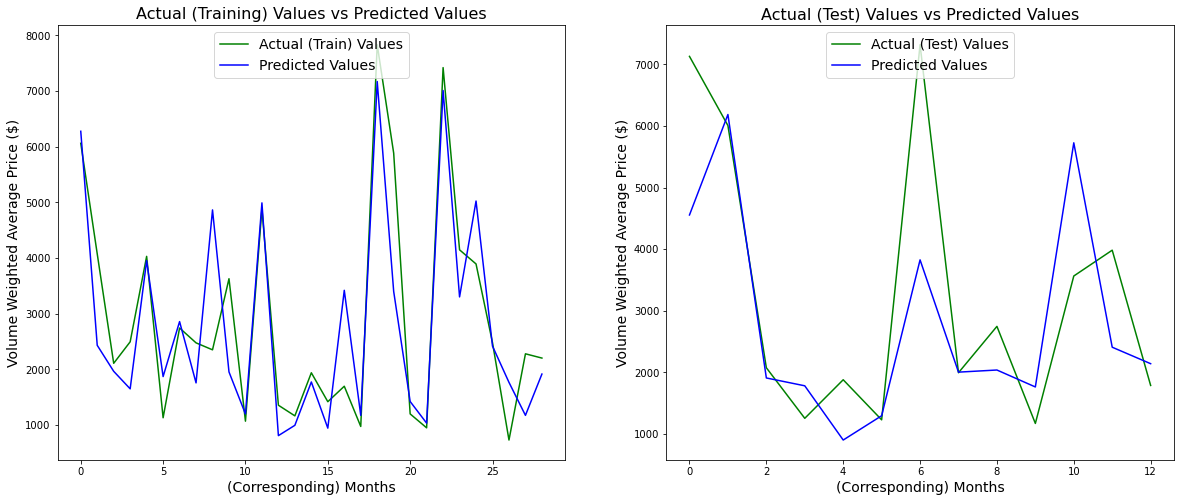

In [28]:
# creating a figure for the comparison of actual and predicted values
plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)

# plotting actual training values and predicted values
plt.plot(y_train, color = 'green', label = 'Actual (Train) Values')
plt.plot(train_predictions, color = 'blue', label = 'Predicted Values')

plt.xlabel('(Corresponding) Months', fontsize = 14)
plt.ylabel('Volume Weighted Average Price ($)', fontsize = 14)

plt.title('Actual (Training) Values vs Predicted Values', fontsize = 16)

# putting a legend into the figure
plt.legend(loc = 'upper center', fontsize = 14)


plt.subplot(1, 2, 2)

# plotting actual training values and predicted values
plt.plot(y_test, color = 'green', label = 'Actual (Test) Values')
plt.plot(test_new_predictions, color = 'blue', label = 'Predicted Values')

plt.xlabel('(Corresponding) Months', fontsize = 14)
plt.ylabel('Volume Weighted Average Price ($)', fontsize = 14)

plt.title('Actual (Test) Values vs Predicted Values', fontsize = 16)

# putting a legend into the figure
plt.legend(loc = 'upper center', fontsize = 14)

# saving the figure
plt.savefig("DNN model performance before pruning.png", dpi = 300)

In [17]:
# number of unit in each Dense layer of the neural network 
N_1 = 64
N_2 = 64

# threshold determines how much loss in performance can be tolerated when pruning
threshold = 0

# the constant is defined in a way that ensures that the reward is bounded between zero and one
constant = 1

Round = 1800

epsilon = 0.5
count = 0

In [18]:
# creating a back-up model
backup_model = load_model('model_unpruned.h5')

start_time = time.time()

N_array = np.zeros(N_1 * N_2)
N_examples = 100

NL = np.zeros(Round)
ep = np.zeros(Round)

avg_accumulative_r_egn = np.zeros(N_1 * N_2)

p_reshape = avg_accumulative_r_egn.reshape(N_1, N_2)

count_egn = np.ones(N_1 * N_2)

# iterating over the number of units in the first Dense layer
for i in range(N_1):
    
    # iterating over the number of units in the second Denes layer
    for j in range(N_2):
        
        # evaluating the model performance
        loss, accuracy = backup_model.evaluate(X_train[1:10], y_train[1:10], batch_size = batch_size, verbose = 0)
        
        # pruning the neuron in the layer
        all_weights = backup_model.get_weights()
        temp = all_weights[2][i][j]
        
        # pulling an arm is considered to be equivalent to setting a weight to zero
        all_weights[2][i][j] = 0
        
        backup_model.set_weights(all_weights)
        
        # evaluating the model performance after setting a weight to zero
        loss_new, accuracy_new = backup_model.evaluate(X_train[1:10], y_train[1:10], batch_size = batch_size, verbose = 0)
        
        # the reward is defined as the difference between the performance score of a network before and after removing a weight
        delta = loss_new - loss
        
        # obtaining the reward
        reward = max(0, threshold + delta) / constant
        
        # returning the weight back before it was pruned
        all_weights[2][i][j] = temp
        
        # collecting the reward
        avg_accumulative_r_egn[count] = reward
        
        backup_model.set_weights(all_weights)
        
        count = count + 1

for j in range(N_1 * N_2 - 1, Round):
    
    b = random.randint(0, N_examples - 1)
    
    # evaluating the model performance using a randomly chosen list of training data points from the dataset
    loss, accuracy = backup_model.evaluate(X_train[b:b+1], y_train[b:b+1], batch_size = batch_size, verbose = 0)
    
    if epsilon > random.uniform(0, 1):
        ind = np.argmax(avg_accumulative_r_egn)
    else:
        ind = random.randint(0, N_1 * N_2 - 1)
    
    i, k = np.unravel_index(ind, p_reshape.shape)
    
    all_weights = backup_model.get_weights()
    
    temp = all_weights[2][i][k]
    all_weights[2][i][k] = 0
    
    backup_model.set_weights(all_weights)
            
    count_egn[ind] = count_egn[ind] + 1
    
    # evaluating the model performance after pruning
    loss_new, accuracy_new = backup_model.evaluate(X_train[b:b+1], y_train[b:b+1], batch_size = batch_size, verbose = 0)
    
    # calculating the reward
    delta = loss_new - loss
    reward = max(0, threshold + delta) / constant
    
    val = count_egn[ind]
    
    avg_accumulative_r_egn[ind] = (val - 1)/val * avg_accumulative_r_egn[ind] + 1/val * reward
    
    all_weights[2][i][j] = temp
    
    backup_model.set_weights(all_weights)
    
    ep[j] = ind

end_time = time.time()

print("Execution time", end_time - start_time)

Execution time 239.71876120567322


In [19]:
rewards = avg_accumulative_r_egn

# deciding on the number of weights to be pruned
number_of_pruned_weights = int(0.10 * N_1 * N_2)

# pruning the weights
for t in range(number_of_pruned_weights):
    
    x = np.argmax(rewards)
    i, k = np.unravel_index(x, p_reshape.shape)
    rewards[x] = -100
    
    all_weights = backup_model.get_weights()
    all_weights[2][i][k] = 0
    
    backup_model.set_weights(all_weights)

# saving the pruned model
backup_model.save('Epsilon_Greedy_model_10_percent.h5')

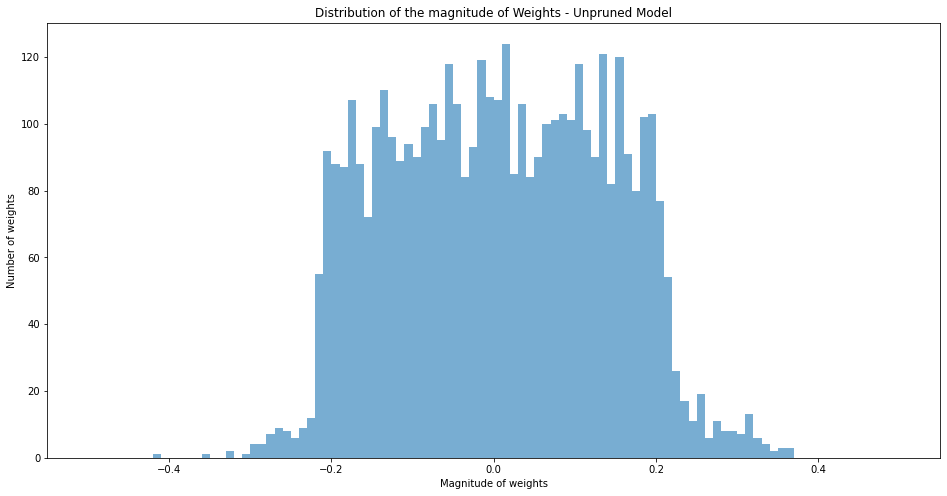

Text(0.5, 1.0, 'Distribution of the magnitude of Weights - pruned 10% of the Model')

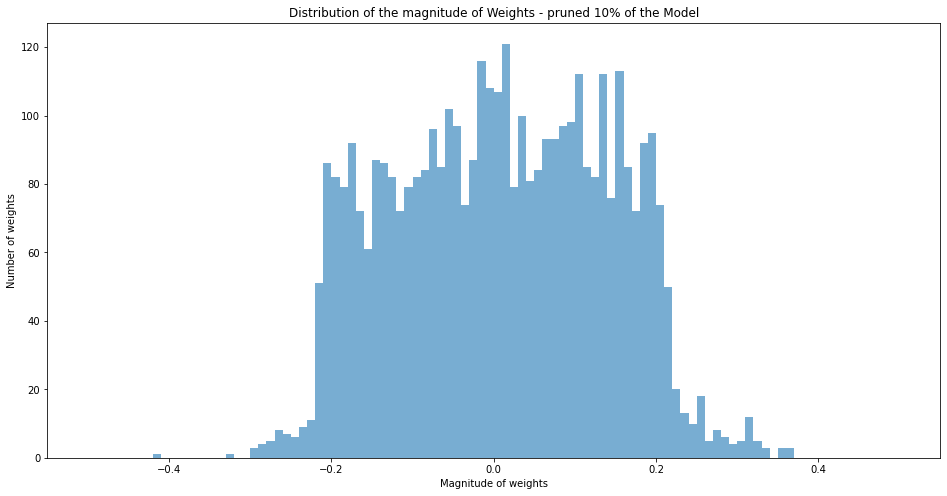

In [24]:
# distribution of the weights before pruning

weights_unpruned = []

for weight in weights:
    
    weight = weight[weight != 0]
    
    weights_unpruned.extend(weight)

# creating a figure and plotting the distribution of the model weights before pruning
plt.figure(figsize = (16, 8))

n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5, 0.5), alpha = 0.6)

# labeling and naming the figure
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()


# distribution of the weights 10% pruning

# loading the  model after pruning
new_model = load_model('Epsilon_Greedy_model_10_percent.h5')

new_weights = new_model.get_weights()

weights_pruned = []

for weight in new_weights:
    
    weight = weight[weight != 0]
    
    weights_pruned.extend(weight)

# creating a figure and plotting the distribution of the model weights before pruning

plt.figure(figsize = (16, 8))

n, bins, patches = plt.hist(weights_pruned, 100, range = (-0.5, 0.5), alpha = 0.6)

# labeling and naming the figure
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - pruned 10% of the Model')

In [21]:
new_model = load_model('Epsilon_Greedy_model_10_percent.h5')

In [22]:
# making predictions using the training dataset to evaluate the training performance of the model
new_train_predictions = new_model.predict(X_train)

# making predictions using the training dataset to evaluate the training performance of the model
new_test_new_predictions = new_model.predict(X_test)

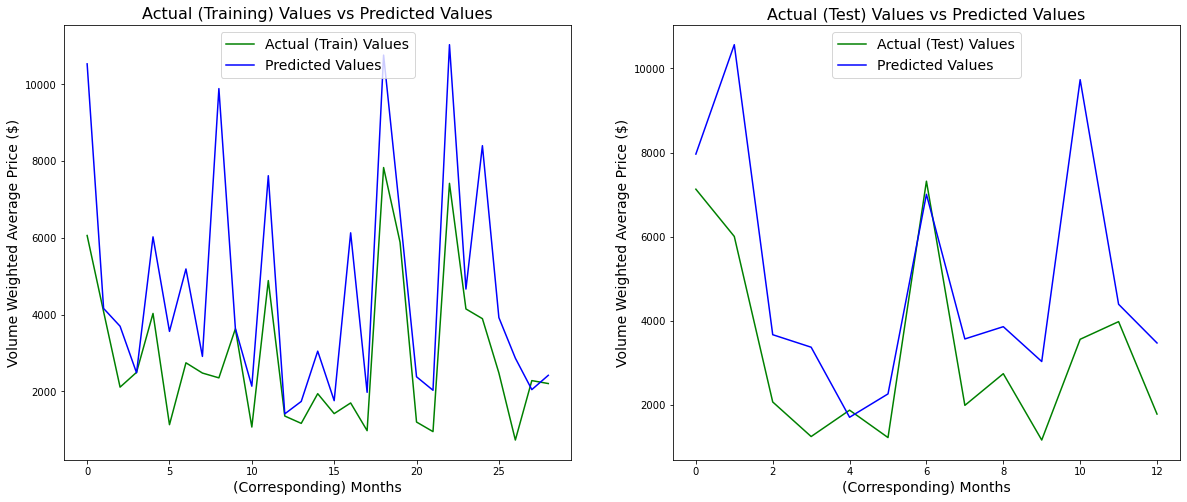

In [30]:
# creating a figure for the comparison of actual and predicted values
plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)

# plotting actual training values and predicted values
plt.plot(y_train, color = 'green', label = 'Actual (Train) Values')
plt.plot(new_train_predictions, color = 'blue', label = 'Predicted Values')

plt.xlabel('(Corresponding) Months', fontsize = 14)
plt.ylabel('Volume Weighted Average Price ($)', fontsize = 14)

plt.title('Actual (Training) Values vs Predicted Values', fontsize = 16)

# putting a legend into the figure
plt.legend(loc = 'upper center', fontsize = 14)


plt.subplot(1, 2, 2)

# plotting actual training values and predicted values
plt.plot(y_test, color = 'green', label = 'Actual (Test) Values')
plt.plot(new_test_new_predictions, color = 'blue', label = 'Predicted Values')

plt.xlabel('(Corresponding) Months', fontsize = 14)
plt.ylabel('Volume Weighted Average Price ($)', fontsize = 14)

plt.title('Actual (Test) Values vs Predicted Values', fontsize = 16)

# putting a legend into the figure
plt.legend(loc = 'upper center', fontsize = 14)

# saving the figure
plt.savefig("DNN model performance after pruning.png", dpi = 300)